In [2]:
import numpy as np
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

In [3]:
data_path = '/scratch/toml/sentinel_2_data'
reference_l2a_name = 'S2A_MSIL2A_20230906T102601_N9999_R108_T32TMT_20230918T123534'
modified_l2a_name =  'S2A_MSIL2A_20230906T102601_N9999_R108_T32TMT_20230918T124854'
capture_time = '20230906T102601'
tile_name = 'L2A_T32TMT_A042862_20230906T103335'
resolution = 60
reference_l2a_path = f"{data_path}/{reference_l2a_name}.SAFE/GRANULE/{tile_name}"
modified_l2a_path  = f"{data_path}/{modified_l2a_name }.SAFE/GRANULE/{tile_name}"

# bands = ['B02', 'B03', 'B04', 'SCL']
bands = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B8A', 'B09', 'B11', 'B12', 'AOT', 'SCL', 'TCI', 'WVP']
reference = {}
modified = {}

for band in bands:
    ref_band_path = f"{reference_l2a_path}/IMG_DATA/R{resolution}m/T32TMT_{capture_time}_{band}_{resolution}m.jp2"
    mod_band_path = f"{modified_l2a_path}/IMG_DATA/R{resolution}m/T32TMT_{capture_time}_{band}_{resolution}m.jp2"

    reference[band] = rasterio.open(ref_band_path, driver='JP2OpenJPEG')
    modified[band] = rasterio.open(mod_band_path, driver='JP2OpenJPEG')


In [4]:
with rasterio.open('ref_rgb.tiff', 'w', driver='Gtiff', 
                   width=reference['B02'].width, height=reference['B02'].height, 
                   count=3, crs=reference['B02'].crs, 
                   transform=reference['B02'].transform, 
                   dtype=reference['B02'].dtypes[0]) as rgb:
    rgb.write(reference['B04'].read(1), 1)
    rgb.write(reference['B03'].read(1), 2)
    rgb.write(reference['B02'].read(1), 3)
    rgb.close()

with rasterio.open('mod_rgb.tiff', 'w', driver='Gtiff',
                     width=modified['B02'].width, height=modified['B02'].height,
                     count=3, crs=modified['B02'].crs,
                     transform=modified['B02'].transform,
                     dtype=modified['B02'].dtypes[0]) as rgb:
    rgb.write(modified['B04'].read(1), 1)
    rgb.write(modified['B03'].read(1), 2)
    rgb.write(modified['B02'].read(1), 3)
    rgb.close()

with rasterio.open('difference_rgb.tiff', 'w', driver='Gtiff',
                    width=modified['B02'].width, height=modified['B02'].height,
                    count=3, crs=modified['B02'].crs,
                    transform=modified['B02'].transform,
                    dtype=modified['B02'].dtypes[0]) as rgb:
    rgb.write(modified['B04'].read(1) - reference['B04'].read(1), 1)
    rgb.write(modified['B03'].read(1) - reference['B03'].read(1), 2)
    rgb.write(modified['B02'].read(1) - reference['B02'].read(1), 3)
    rgb.close()


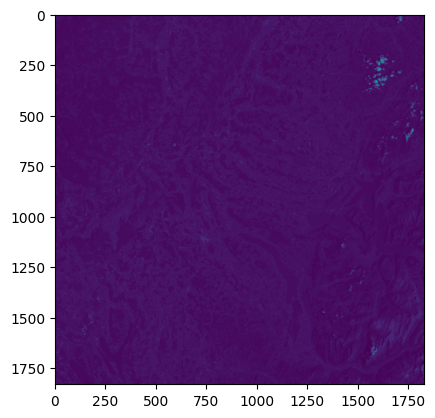

In [5]:
plt.show(plt.imshow(np.moveaxis(reference['B03'].read(1), 0, -1)))

In [6]:
def scl_to_rgb(rio_scl):
    # map the data to the following colors
    colour_dict = {
        0: (0, 0, 0),  # black: no data
        1: (255,0,0),  # red: saturated or defective
        2: (50,50,50),  # dark grey: casted shadows
        3: (165,42,42),  # brown: cloud shadows
        4: (0,100,0),  # green: vegetation
        5: (255,255,0),  # yellow: bare soils
        6: (0,0,255),  # blue: water
        7: (128,128,128),  # grey: unclassified
        8: (211,211,211),  # light grey: cloud medium probability
        9: (255,255,255),  # white: cloud high probability
        10: (0,255,255),  # light blue: thin cirrus
        11: (255,192,203)  # pink: snow
    }

    # create a new array with the same shape as the original data
    # but with 3 channels (RGB)
    scl_array = rio_scl.read(1)
    rgb = np.zeros((rio_scl.height, rio_scl.width, 3), dtype=np.uint8)

    # map the data to RGB
    for k, v in colour_dict.items():
        rgb[scl_array == k] = v

    # plot the RGB image
    import matplotlib.pyplot as plt
    plt.imshow(rgb)
    plt.show()


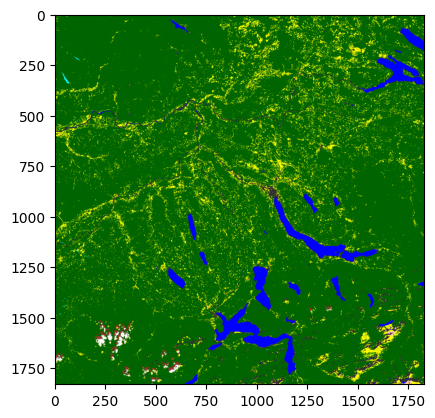

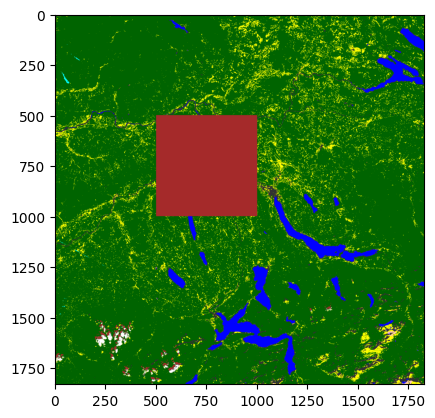

In [7]:
scl_to_rgb(reference['SCL'])
scl_to_rgb(modified['SCL'])

B01: no difference
B02: no difference
B03: no difference
B04: no difference
B05: 65535


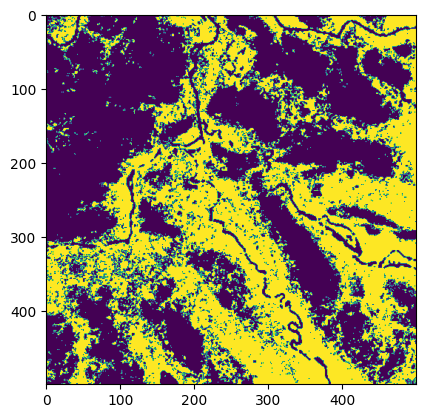

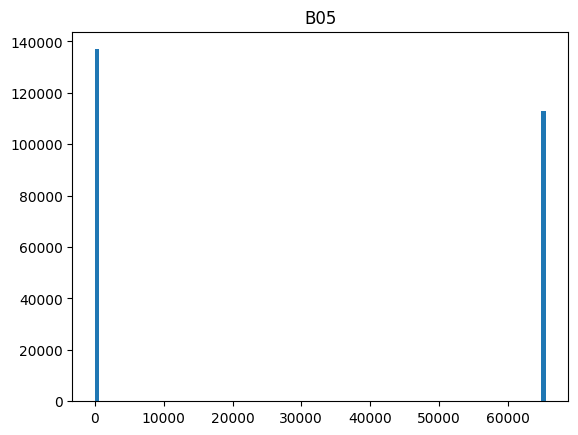

B06: 65535


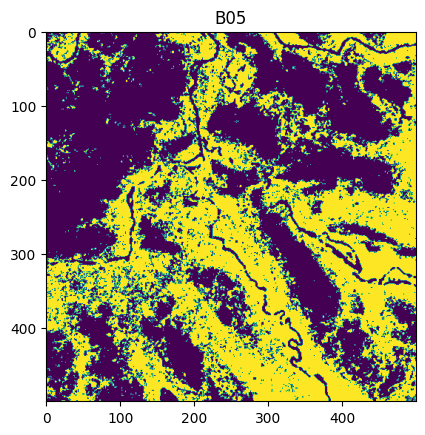

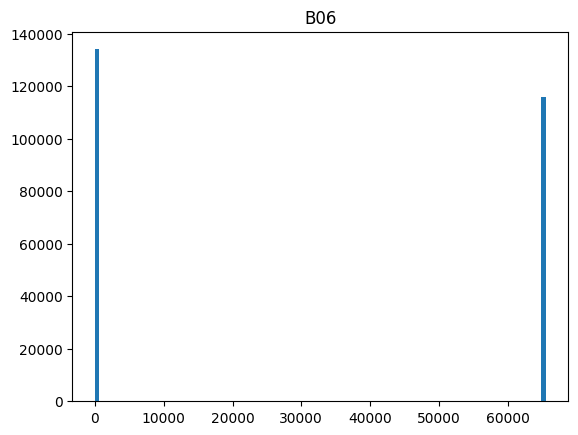

B07: 65535


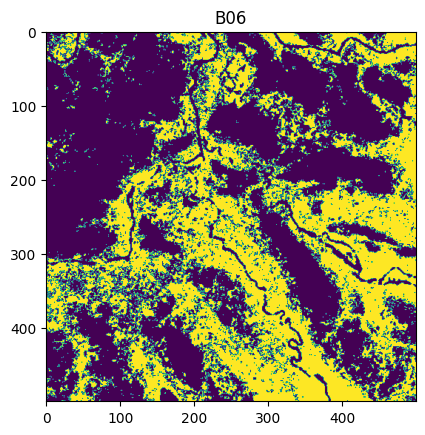

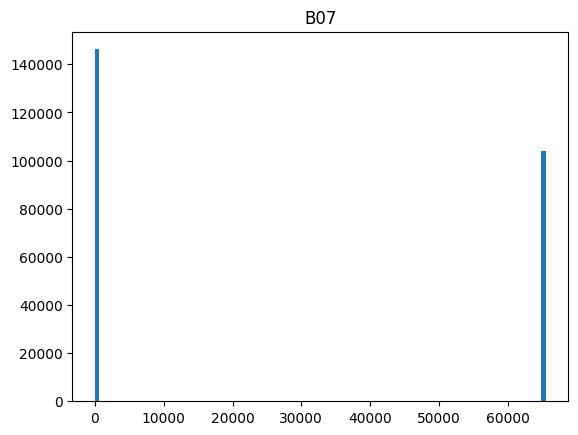

B8A: no difference
B09: 65535


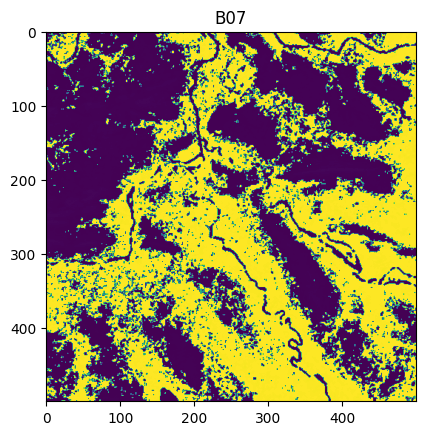

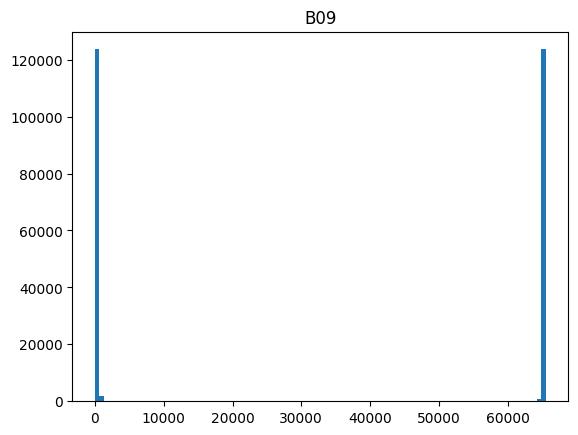

B11: 65535


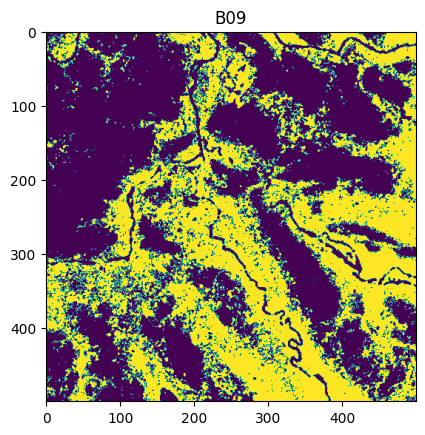

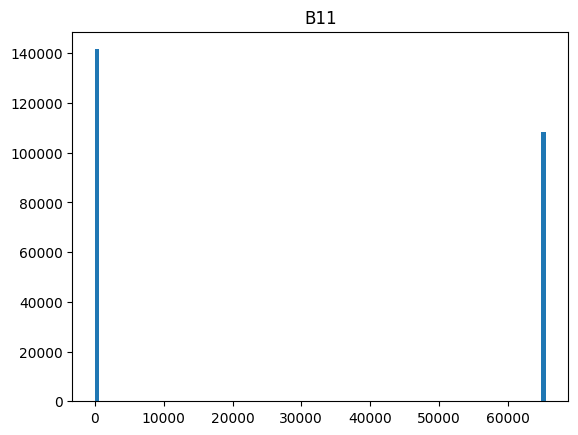

B12: 65535


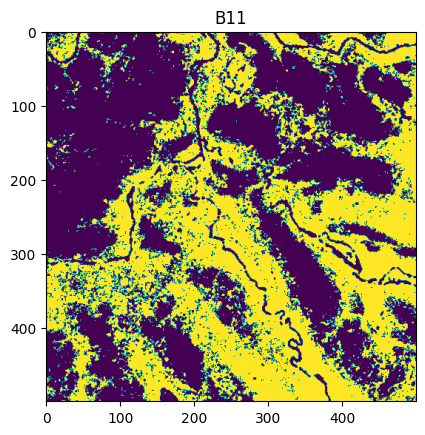

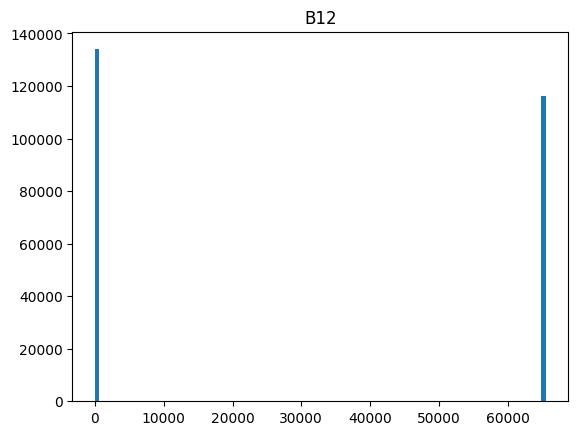

AOT: no difference
SCL: 255


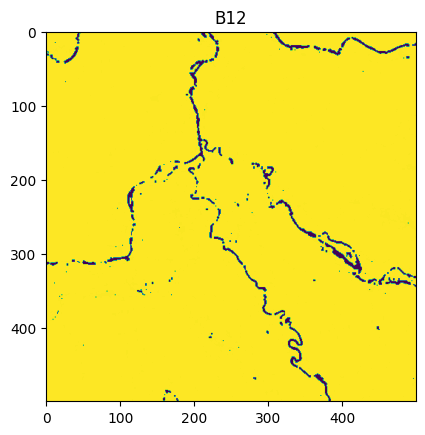

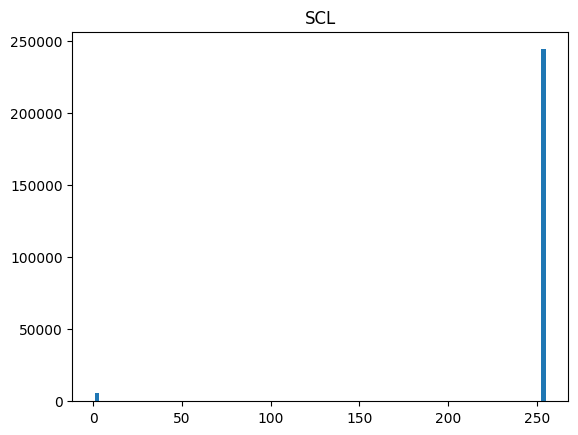

TCI: no difference
WVP: 65535


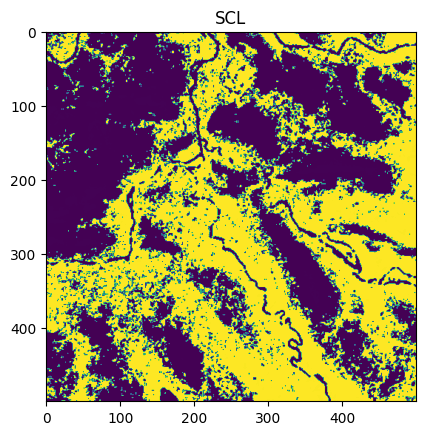

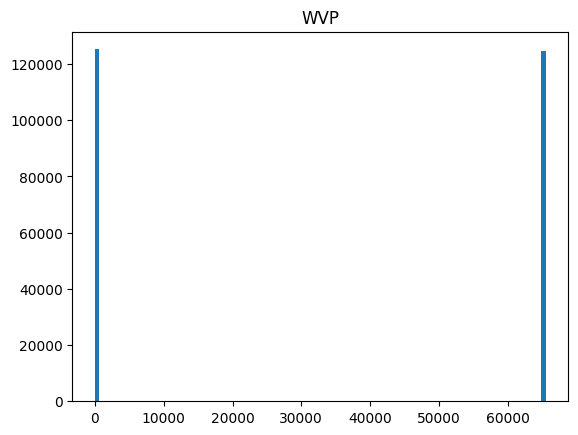

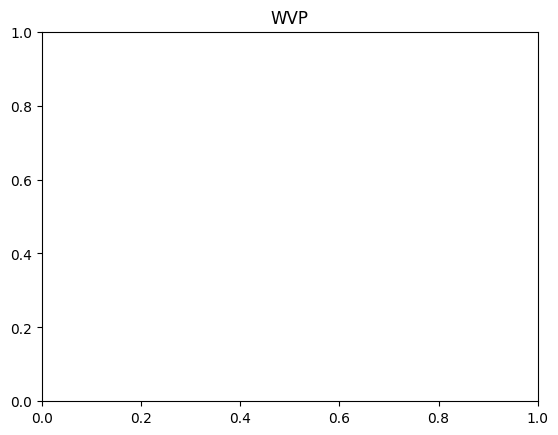

In [8]:
#compare bands

for band in bands:
    diff_array = modified[band].read(1)[500:1000,500:1000] - reference[band].read(1)[500:1000,500:1000]
    zero = np.zeros(diff_array.shape)
    if not np.array_equal(diff_array, zero):
        print(f"{band}: {np.max(diff_array)}")
        # plot difference and band name
        plt.show(plt.imshow(diff_array))
        plt.title(band)
        # plot histogram
        plt.show(plt.hist(diff_array.flatten(), bins=100))
        plt.title(band)
    else:
        print(f"{band}: no difference")